### imports

In [ ]:
import numpy as np
from numpy import random
from numpy.linalg import inv
from IPython.display import Audio, display
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from scipy import signal
import torch
from torch import nn
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import MultiHeadAttention, LayerNormalization, Layer, Dense, Dropout, Flatten, Embedding, Add
import os
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### audio feature extraction

In [164]:
# populate the rows of the matrix H with sinusoids at every frequency produced by the guitar, sampled at Fs for dur seconds
def F(k,res=5):
  calibration = -1.5
  return 440 * 2**(((k/res)-29.5+calibration+(1/(2*res)))/12)

def W(k,N=4410,Fs=44100,res=5):
  out = np.zeros((2,N))
  for i in range(N):
    out[0,i] = np.real(np.exp(-1j * 2 * np.pi * i * F(k,res) / Fs))
    out[1,i] = np.imag(np.exp(-1j * 2 * np.pi * i * F(k,res) / Fs))
  return out

def make_H(num_tones=48,N=4410,res=5):
  Hre = np.zeros((num_tones,N))
  Himag = np.zeros((num_tones,N))
  for k in range(num_tones):
    Hre[k] = W(k,N,res=res)[0]
    Himag[k] = W(k,N,res=res)[1]
  H = Hre + 1j * Himag
  return H

In [165]:
#H = make_H(num_tones=48*5,N=int(44100*5),res=5)
#np.save('/content/drive/My Drive/FretboardAI/H5c',H)

In [179]:
def audio2tones(file_name, play_audio=False, make_plots=False, Fs=44100):
  # params
  num_tones = 48
  res = 5
  num_tones = num_tones * res
  window_length = 0.1 # seconds
  N = int(Fs * window_length) # samples (per window)
  drive_path = '/content/drive/My Drive/FretboardAI/'
  scale = ['E','F','F#','G','G#','A','A#','B','C','C#','D','D#']
  tone_labels = [scale[np.mod(int(i/res),len(scale))] if np.mod(i+3,res) == 0 else ' ' for i in range(num_tones)]
  Q = 8
  chord_onset_threshold = 0.5
  min_chord_window = 1 # seconds
  note_threshold = 0.03

  # load H matrix from drive
  H = np.load(drive_path + 'H5c.npy')

  # store and plot custom audio file
  sample_file_name = drive_path + 'audio/' + file_name

  if play_audio:
    # play audio
    print('Playing audio file: ' + sample_file_name)
    display(Audio(sample_file_name, autoplay=False))
    print()

  # break up the audio into windows to prepare for onset detection. Longer windows allow for less resolution.
  input_data = read(sample_file_name)
  audio = input_data[1]
  audio_windows = []
  windows = int(len(audio)/N)
  for i in range(windows):
    audio_windows.append(audio[i*N:(i+1)*N])
  audio = np.array(audio_windows)
  audio = audio[:,:,0]

  # extract frequency content by multiplying the audio signal by the matrix H
  # the rows of H are sampled sinusoids with frequencies near the notes possible on the guitar in standard tuning
  # the matrix multiplication procedure extracts the inner products of the audio signal with these sinusoids
  # this is essentially like taking a Fourier Transform of the signal only at the frequencies i am interested in
  # H = make_H(num_tones=num_tones,N=N)
  tones = []
  for i in range(windows):
    tones.append(np.abs(H[:,:N] @ audio[i])) # take inner product of audio with tone matrix for each audio window
    tones[i] = tones[i] ** 2 # square each tone value
  tones = np.array(tones)

  # find the onsets in the audio by measuring the differences in energy from one window to the next
  # i measure energy in a given window by normalizing the values of the array to 1 and summing the amplitudes of each frequency bin
  max_tone = max([max(tones[i]) for i in range(windows)])
  onsets = []
  diffs = []
  for i in range(windows):
    if len(onsets) == 0 or i*N - onsets[-1] > min_chord_window*Fs:
      tones[i] = np.round(tones[i]/max_tone,2)
      diff = np.sum(tones[i])-np.sum(tones[i-1]) if i != 0 else np.sum(tones[i])
      diffs.append(diff)
      if diff > chord_onset_threshold:
        onsets.append(i*N)

  # rewindow the audio according to the chord onsets
  audio = input_data[1]
  audio = np.array(audio)
  audio = audio[:,0]
  audio_windows = []
  chord_windows = int(len(onsets))
  for i in range(chord_windows):
    if i == chord_windows - 1:
      audio_windows.append(audio[onsets[i]-1000:])
    else:
      audio_windows.append(audio[onsets[i]-1000:onsets[i+1]-1000])
  resized_audio = audio_windows.copy()

  # extract the frequency content in each window
  tones = []
  for i in range(chord_windows):
    tones.append(np.abs(H[:,:len(resized_audio[i])] @ resized_audio[i])) # take inner product of audio with tone matrix for each audio window
    tones[i] = tones[i] ** 2 # square each tone value
  tones = np.array(tones)

  # max pooling according to the variable res
  # this averages the power around each tone---res refers to how many samples around the tone are used in the average
  # the H matrix saved in my drive uses a default res of 5
  tones_consolidated = []
  for j in range(chord_windows):
    tones_consolidated.append(np.array([np.mean(tones[j][i*res:i*res+res]) for i in range(int(len(tones[j])/res))]))
  tones_consolidated = np.array(tones_consolidated)
  tone_labels_consolidated = [scale[np.mod(i,len(scale))] for i in range(len(tones_consolidated[0]))]

  # normalize the values of the max-pooled array to 1
  # this gives me a 'tones array' with 48 entries corresponding to the energy sensed in each guitar tone
  window_maximums = [max(tones_consolidated[i]) for i in range(chord_windows)]
  for i in range(chord_windows):
    tones_consolidated[i] = np.round(tones_consolidated[i]/window_maximums[i],2)

  # simplify the values of the tones vector to binary
  # tones are determined to be played if the value of its entry in the tones array is both greater than its neighboring entries and it is greater than some threshold
  tones_binary = np.zeros((chord_windows,len(tones_consolidated[0])),int)
  for j in range(chord_windows):
    for i in range(len(tones_consolidated[j])):
      if (i != 0 and tones_consolidated[j][i] < tones_consolidated[j][i-1]) or (i+1 < len(tones_consolidated[j]) and tones_consolidated[j][i] < tones_consolidated[j][i+1]):
        tones_binary[j][i] = 0
      elif tones_consolidated[j][i] > note_threshold: tones_binary[j][i] = 1

  # convert binary array to a sequence of tokens. Tokens are made by converting sets of Q binary entries in the tones array to decimal
  # i use 48 tones on the guitar because this nicely simplifies the tones array to a sequence of 6 tokens using Q=8
  # this is the final result; i have simplified the audio signal in time to a sequence of 6 tokens denoting the guitar notes played in the audio
  num_tokens = int(num_tones/(Q*res)) # per window
  tokens = [[0 for i in range(num_tokens)] for j in range(chord_windows)]
  binaries = [pow(2,i) for i in range(Q)]
  for j in range(chord_windows):
    for i in range(num_tokens):
      b = tones_binary[j][i*Q:i*Q+Q]
      tokens[j][i] = np.inner(binaries,b)

  if make_plots:
    # plot time signal
    raw_audio = input_data[1]
    raw_audio = np.array(raw_audio)
    raw_audio = raw_audio[:,0]
    plt.figure(figsize=(20,4))
    plt.plot(raw_audio)
    plt.plot([onsets[i] for i in range(len(onsets))], [0 for i in range(len(onsets))], 'ro')
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.title("Audio Sample")
    plt.show()
    print()
    print('Number of chords detected: '+str(chord_windows))
    print()

    # # plot spectrogram
    # f, t, Sxx = signal.spectrogram(raw_audio, Fs, nfft=2048)
    # plt.figure(figsize=(20,4))
    # plt.pcolormesh(t, f, Sxx, shading='gouraud')
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    # plt.ylim(0, 1000) # max freq
    # plt.title('Spectrogram')
    # plt.colorbar()
    # plt.show()
    # print()

    # plot the max-pooled tones array for each window (meaning each onset)
    plt.figure(figsize=(20,4))
    plt.imshow(tones_consolidated)
    plt.xlabel('Tone')
    plt.ylabel('Chord')
    plt.title('Frequency content of each chord detected in the audio')
    plt.xticks(range(len(tone_labels_consolidated)),tone_labels_consolidated)
    plt.colorbar()
    plt.show()
    print()

    # plot the binary tones array for each window
    plt.figure(figsize=(20,4))
    plt.imshow(tones_binary)
    plt.xlabel('Tone')
    plt.ylabel('Chord')
    plt.title('Frequency content of each chord detected in the audio (reduced to binary)')
    plt.xticks(range(len(tone_labels_consolidated)),tone_labels_consolidated)
    plt.colorbar()
    plt.show()
    print()

  # print detected tones
  # max_tones = []
  # for i in range(chord_windows):
  #   for j in range(len(tones_consolidated[i])):
  #     if i == 0:
  #       if tones_consolidated[i][j] > onset_threshold: max_tones.append(j)
  #     elif tones_consolidated[i][j] - tones_consolidated[i-1][j] > onset_threshold:
  #       max_tones.append(j)
  # max_tones = np.array(max_tones)
  # notes_found = [tone_labels_consolidated[max_tones[i]] for i in range(len(max_tones))]
  # print('Sounds like you played the notes : ' + str(notes_found))
  # print()

  return tokens

### transformer models


#### tones2tab

##### model

In [ ]:
# params
T = 48
Q = 8 # T/Q should be an integer
N = int(T/Q)
D = 96
dff = 4*D
H = 8
L = 6
dropout_rate = 0.1
batch_size = 32
t2t_vocab_length = pow(2,Q)
t2t_output_dim = 25 # one token for each of 24 possible frets and another to denote the string is muted
A = 440 # Hz
guitar = [[A*pow(2,(-29+i)/12) for i in range(24)],
          [A*pow(2,(-24+i)/12) for i in range(24)],
          [A*pow(2,(-19+i)/12) for i in range(24)],
          [A*pow(2,(-14+i)/12) for i in range(24)],
          [A*pow(2,(-10+i)/12) for i in range(24)],
          [A*pow(2,(-5+i)/12) for i in range(24)]]

def t2t_positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class T2TPositionalEmbedding(Layer):
  def __init__(self, vocab_size=t2t_vocab_length, dim_model=D):
    super().__init__()
    self.d_model = dim_model
    self.embedding = Embedding(input_dim=vocab_size, output_dim=dim_model, mask_zero=True)
    self.pos_encoding = t2t_positional_encoding(length=2048, depth=dim_model)

  def call(self, x):
    chords = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :chords, :]
    return x

class T2TBaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

class T2TGlobalSelfAttention(T2TBaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    return self.layernorm(x)

class T2TFeedForward(Layer):
  def __init__(self, dim_model=D, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.seq = tf.keras.Sequential([
      Dense(dim_mlp, activation='relu'),
      Dense(dim_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layer_norm(x)

class T2TEncoder(Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.self_attention = T2TGlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = T2TFeedForward(dim_model=dim_model, dim_mlp=dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

class Tones2Tab(tf.keras.Model):
    def __init__(self, *, output_dim=t2t_output_dim, dim_model=D, seq_length=N, dim_mlp=dff, L=L, dropout_rate=dropout_rate):
        super().__init__()
        self.dim_model = dim_model
        self.L = L

        self.embed = T2TPositionalEmbedding()
        self.encoder_layers = [T2TEncoder() for _ in range(L)]
        self.dropout = Dropout(dropout_rate)

        self.mlp_head1 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head2 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head3 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head4 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head5 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head6 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])

    def call(self, x): # x is (None, N) where None refers to batch size
        b = tf.shape(x)[0]
        x = self.embed(x) # (None, N, dim_model)
        x = self.dropout(x)
        for i in range(self.L): x = self.encoder_layers[i](x)

        flatten = Flatten()
        x = flatten(x) # (None, N*dim_model)
        s1 = tf.nn.softmax(self.mlp_head1(x)) # (None, number of frets)
        s2 = tf.nn.softmax(self.mlp_head2(x)) # (None, number of frets)
        s3 = tf.nn.softmax(self.mlp_head3(x)) # (None, number of frets)
        s4 = tf.nn.softmax(self.mlp_head4(x)) # (None, number of frets)
        s5 = tf.nn.softmax(self.mlp_head5(x)) # (None, number of frets)
        s6 = tf.nn.softmax(self.mlp_head6(x)) # (None, number of frets)

        # consolidate csf outputs
        y = []
        for i in range(b):
          y.append([s1[i],s2[i],s3[i],s4[i],s5[i],s6[i]])
        out = tf.stack(y)

        return out

t2t = Tones2Tab()
t2t.load_weights('/content/drive/My Drive/FretboardAI/tones2tab')

##### functions

In [158]:
def tones2tab(tones,model=t2t,make_plots=False):
  input = tf.convert_to_tensor(tones, dtype=tf.int32)
  soft = model(input)
  output = []
  for j in range(len(tones)):
    w_output = []
    for i in range(len(tones[j])):
      w_output.append(int(tf.math.argmax(soft[j][i])))
    output.append(w_output)

  if make_plots:
    soft_plot = [[soft[j][len(soft[0])-i-1][1:] for i in range(len(soft[0]))] for j in range(len(soft))]
    fig, ax = plt.subplots(len(soft_plot),1, figsize=(20,4*len(soft_plot)))
    plt.set_cmap('viridis')
    if len(soft_plot) > 1:
      for i in range(len(soft_plot)):
        ax[i].set_title('Softmax output depicting the most likely fretboard pattern for chord '+str(i+1))
        ax[i].imshow(soft_plot[i])
        if i == len(soft_plot) - 1: ax[i].set_xlabel('Fret')
        else: ax[i].set_xlabel('')
        ax[i].set_ylabel('String')
        ax[i].set_yticks(range(len(guitar)),['e','B','G','D','A','E'])
        ax[i].set_xticks(range(len(guitar[0])),range(len(guitar[0])))
    else:
      for i in range(len(soft_plot)):
        ax.set_title('Softmax output depicting the most likely fretboard pattern for chord '+str(i+1))
        ax.imshow(soft_plot[i])
        if i == len(soft_plot) - 1: ax.set_xlabel('Fret')
        else: ax.set_xlabel('')
        ax.set_ylabel('String')
        ax.set_yticks(range(len(guitar)),['e','B','G','D','A','E'])
        ax.set_xticks(range(len(guitar[0])),range(len(guitar[0])))
    plt.show()
    print()

  return output

In [64]:
def print_tab(tab):
  out = []
  for j in range(len(tab[0])):
    string = ''
    for i in range(len(tab)):
      if tab[i][j] > 0:
        string = string + ' ' + str(tab[i][j]-1) + ' '
      else:
        string = string + ' - '
    out.append(string)
  print('Guitar tablature:')
  print()
  for i in range(len(tab[0])):
    print(out[len(tab[0])-i-1])
    print()
  return out

#### tab2chord

##### model

In [ ]:
N = 6 # guitar tab input
D = 512
H = 8
L = 6
dff = D*4
batch_size = 32
t2c_vocab_length = 25
t2c_output_dim = 15 # csf output
dropout_rate = 0.1

def t2c_positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class T2CPositionalEmbedding(Layer):
  def __init__(self, vocab_size=t2c_vocab_length, dim_model=D):
    super().__init__()
    self.d_model = dim_model
    self.embedding = Embedding(input_dim=vocab_size, output_dim=dim_model, mask_zero=True)
    self.pos_encoding = t2c_positional_encoding(length=2048, depth=dim_model)

  def call(self, x):
    chords = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :chords, :]
    return x

class T2CBaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

class T2CGlobalSelfAttention(T2CBaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    return self.layernorm(x)

class T2CFeedForward(Layer):
  def __init__(self, dim_model=D, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.seq = tf.keras.Sequential([
      Dense(dim_mlp, activation='relu'),
      Dense(dim_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layer_norm(x)

class T2CEncoder(Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.self_attention = T2CGlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = T2CFeedForward(dim_model=dim_model, dim_mlp=dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

class Tab2Chord(tf.keras.Model):
    def __init__(self, *, output_dim=t2c_output_dim, dim_model=D, seq_length=N, dim_mlp=dff, L=L, dropout_rate=dropout_rate):
        super().__init__()
        self.dim_model = dim_model
        self.L = L

        self.embed = T2CPositionalEmbedding()
        self.encoder_layers = [T2CEncoder() for _ in range(L)]
        self.dropout = Dropout(dropout_rate)

        self.mlp_head1 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head2 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head3 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])

    def call(self, x): # x is (None, N) where None refers to batch size
        b = tf.shape(x)[0]
        x = self.embed(x) # (None, N, dim_model)
        x = self.dropout(x)
        for i in range(self.L): x = self.encoder_layers[i](x)

        flatten = Flatten()
        x = flatten(x) # (None, N*dim_model)
        c = tf.nn.softmax(self.mlp_head1(x)) # (None, number of frets)
        s = tf.nn.softmax(self.mlp_head2(x)) # (None, number of frets)
        f = tf.nn.softmax(self.mlp_head3(x)) # (None, number of frets)

        # consolidate csf outputs
        y = []
        for i in range(b):
          y.append([c[i], s[i], f[i]])
        out = tf.stack(y)

        return out

t2c = Tab2Chord()
t2c.load_weights('/content/drive/My Drive/FretboardAI/tab2chord')

##### functions

In [159]:
def tab2chord(tab,model=t2c,make_plots=False):
  tab_nonzero = []
  for i in range(len(tab)):
    if np.sum(tab[i]) != 0: tab_nonzero.append(tab[i])
  input = tf.convert_to_tensor(tab_nonzero, dtype=tf.int32)
  soft = model(input)
  output = []
  for i in range(len(tab_nonzero)):
    output.append([int(tf.math.argmax(soft[i][0])),int(tf.math.argmax(soft[i][1])),int(tf.math.argmax(soft[i][2]))])

  if make_plots:
    print('Each plot below corresponds to a single chord shape')
    print('The plots depict how the model characterizes a given fretboard pattern (a column in the tablature) based on three key characterisitics')
    print('First characteristic: what fret is the pattern played at? 0-24')
    print('Second characteristic: which of the basic chord shapes does the pattern use? C/A/G/E/D')
    print('Third characteristic: how does the pattern modify the basic pattern? major/minor')
    print('So far, I have only trained the model to recognize major or minor modifications')
    print('However, I can easily incorporate 7ths, 6ths, 9ths, dim, aug, sus et al. shapes into the training dataset')
    print()
    print('The model classifies each column of tablature (each fretboard pattern) in this way')
    print('For key classification, which is the next step in my model, each fretboard pattern is assigned a unique token only based on these three characteristics')
    print('This method of chord classification therefore allows my model to recognize the different ways of playing a single chord on a guitar, as they are tokenized differently')
    print()
    soft_plot = [[soft[j][len(soft[0])-i-1] for i in range(len(soft[0]))] for j in range(len(soft))]
    fig, ax = plt.subplots(len(soft_plot),1, figsize=(20,4*len(soft_plot)))
    if len(soft_plot) > 1:
      for i in range(len(soft_plot)):
        ax[i].set_title('Softmax output depicting the most likely characteristics of chord '+str(i+1)+' on the fretboard')
        ax[i].imshow(soft_plot[i])
        if i == len(soft_plot)-1: ax[i].set_xlabel('Characteristic description indeces (0-14 possible fret positions , C/A/G/E/D possible basic shapes , maj/min possible modifications)')
        else: ax[i].set_xlabel('')
        ax[i].set_ylabel('Characteristic')
        ax[i].set_yticks(range(3),['Fret position','Basic shape','Modification'])
    else:
      for i in range(len(soft_plot)):
        ax.set_title('Softmax output depicting the most likely characteristics of chord '+str(i+1)+' on the fretboard')
        ax.imshow(soft_plot[i])
        if i == len(soft_plot)-1: ax.set_xlabel('Characteristic description indeces (0-14 possible fret positions , C/A/G/E/D possible basic shapes , maj/min possible modifications)')
        else: ax.set_xlabel('')
        ax.set_ylabel('Characteristic')
        ax.set_yticks(range(3),['Fret position','Basic shape','Modification'])
    plt.show()
    print()

  return output

In [59]:
def chord2token(chord):
  return chord[0]*5*15 + chord[1]*15 + chord[2] + 1

In [58]:
def chord2name(chord):
  estring = ['E','F','F#','G','G#','A','A#','B','C','C#','D','D#','E','F','F#','G','A','A#']
  astring = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#','A','A#','B','C','C#','D']
  dstring = ['D','D#','E','F','F#','G','G#','A','A#','B','C','C#','D','D#','E','F','F#','G']
  name = ''
  color = chord[0]
  shape = chord[1]
  bar = chord[2]
  if shape == 0: name = name + astring[bar+3]
  elif shape == 1: name = name + astring[bar]
  elif shape == 2: name = name + estring[bar+3]
  elif shape == 3: name = name + estring[bar]
  elif shape == 4: name = name + dstring[bar]
  if color == 1: name = name + 'm'
  return name

In [68]:
def print_chord(chord):
  for i in range(len(chord)):
    color = chord[i][0]
    shape = chord[i][1]
    bar = chord[i][2]
    if bar != 0: print('The model guesses that chord '+str(i+1)+' has a bar at fret '+str(bar)+',', end=' ')
    else: print('The model guesses that chord '+str(i+1)+' is played open,', end=' ')
    if shape == 0: print('using the C chord shape', end=' ')
    elif shape == 1: print('using the A chord shape', end=' ')
    elif shape == 2: print('using the G chord shape', end=' ')
    elif shape == 3: print('using the E chord shape', end=' ')
    elif shape == 4: print('using the D chord shape', end=' ')
    if color == 0:  print('in its major form.')
    elif color == 1: print('in its minor form.')
    print()

#### seq2key

In [ ]:
N = 4
D = 512
H = 8
L = 6
dff = D*4
batch_size = 32
s2k_vocab_length = 150 # possible fretboard shapes the code learns from
s2k_output_dim = 12 # possible key labels
dropout_rate = 0.1

def s2k_positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class S2KPositionalEmbedding(Layer):
  def __init__(self, vocab_size=s2k_vocab_length, dim_model=D):
    super().__init__()
    self.d_model = dim_model
    self.embedding = Embedding(input_dim=vocab_size, output_dim=dim_model, mask_zero=True)
    self.pos_encoding = s2k_positional_encoding(length=2048, depth=dim_model)

  def call(self, x):
    chords = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :chords, :]
    return x

class S2KBaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

class S2KGlobalSelfAttention(S2KBaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    return self.layernorm(x)

class S2KFeedForward(Layer):
  def __init__(self, dim_model=D, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.seq = tf.keras.Sequential([
      Dense(dim_mlp, activation='relu'),
      Dense(dim_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layer_norm(x)

class S2KEncoder(Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.self_attention = S2KGlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = S2KFeedForward(dim_model=dim_model, dim_mlp=dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

class Seq2Key(tf.keras.Model):
    def __init__(self, *, output_dim=s2k_output_dim, dim_model=D, seq_length=N, dim_mlp=dff, L=L, dropout_rate=dropout_rate):
        super().__init__()
        self.dim_model = dim_model
        self.L = L

        self.embed = S2KPositionalEmbedding()
        self.encoder_layers = [S2KEncoder() for _ in range(L)]
        self.dropout = Dropout(dropout_rate)

        self.mlp_head = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])

    def call(self, x): # x is (None, N) where None refers to batch size
        x = self.embed(x) # (None, N, dim_model)
        x = self.dropout(x)
        for i in range(self.L): x = self.encoder_layers[i](x)

        flatten = Flatten()
        x = flatten(x) # (None, N*dim_model)
        pred = self.mlp_head(x) # (None, 12)

        pred = tf.nn.softmax(pred)

        return pred

s2k = Seq2Key()
s2k.load_weights('/content/drive/My Drive/FretboardAI/seq2key')

In [92]:
def seq2key(seq,model=s2k,make_plots=False):
  if len(seq) > 4:
    seq = seq[-4:]
  elif len(seq) < 4:
    for i in range(4-len(seq)): seq.append(seq[np.mod(i,len(seq))])
  input = tf.convert_to_tensor([seq], dtype=tf.int32)
  soft = model(input)[0]
  key_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B','Cm','C#m','Dm','D#m','Em','Fm','F#m','Gm','G#m','Am','A#m','Bm']

  if make_plots:
    plt.figure(figsize=(20,4))
    plt.title('Softmax output depicting the most likely key based on the last four (or less) chords played')
    plt.imshow([soft])
    plt.xlabel('Possible keys')
    plt.ylabel('Progression index')
    plt.xticks(range(12),key_names[:12])
    plt.colorbar()
    plt.show()
    print()

  return key_names[np.argmax(soft)]

### main audio conversion function

In [88]:
def convert(input,make_plots=False,play_audio=False):
  # audio frequency component extraction
  tones_seq = audio2tones(input,play_audio=play_audio,make_plots=make_plots)

  # convert frequency content to reasonable guitar tablature
  tab = tones2tab(tones_seq,make_plots=make_plots)
  neat_tab = print_tab(tab)

  # express guitar tablature as a sequence of fretboard patterns
  chord = tab2chord(tab,make_plots=make_plots)
  print_chord(chord)

  # convert the sequence of fretboard patterns to a sequence of tokens
  seq = [] # chord tokens
  prog = [] # chord names
  for i in range(len(chord)): # for each window with a chord detected
    chord_name = chord2name(chord[i])
    print('Chord '+str(i+1)+' guess: ' + chord_name)
    prog.append(chord_name)
    seq.append(chord2token(chord[i]))
  print()

  # classify the sequence of tokens as one of 12 musical keys
  key = seq2key(seq,make_plots=make_plots)
  print('Key guess: ' + key)

  return neat_tab, chord, prog, key

### testing

Playing audio file: /content/drive/My Drive/FretboardAI/audio/Dmaj.wav


<ipython-input-179-947bf1c76764>:29: WavFileWarning: Chunk (non-data) not understood, skipping it.
  input_data = read(sample_file_name)


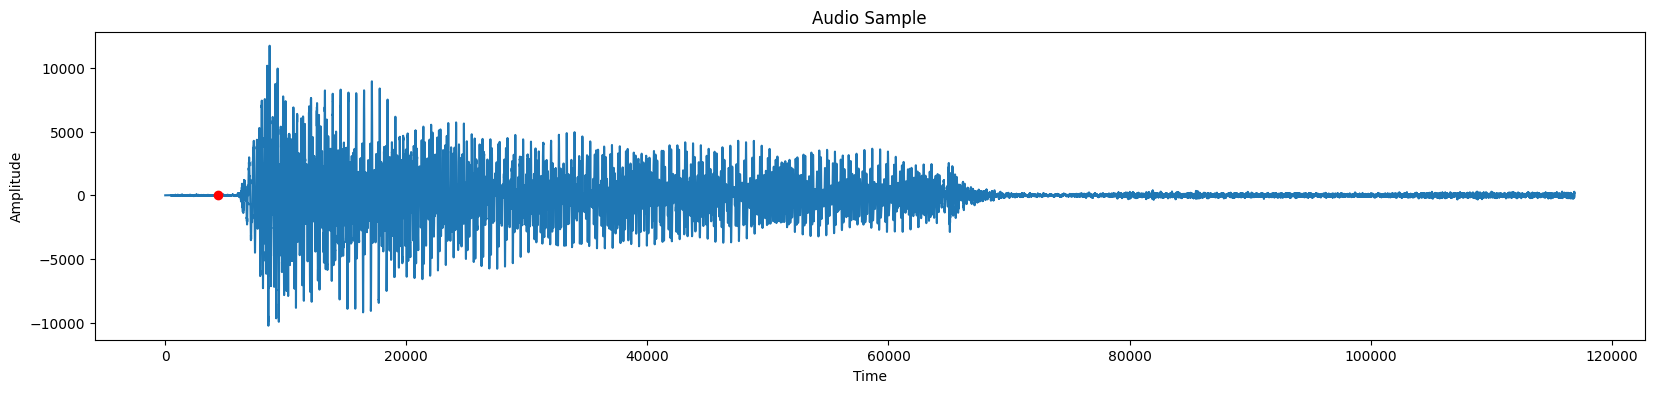


Number of chords detected: 1



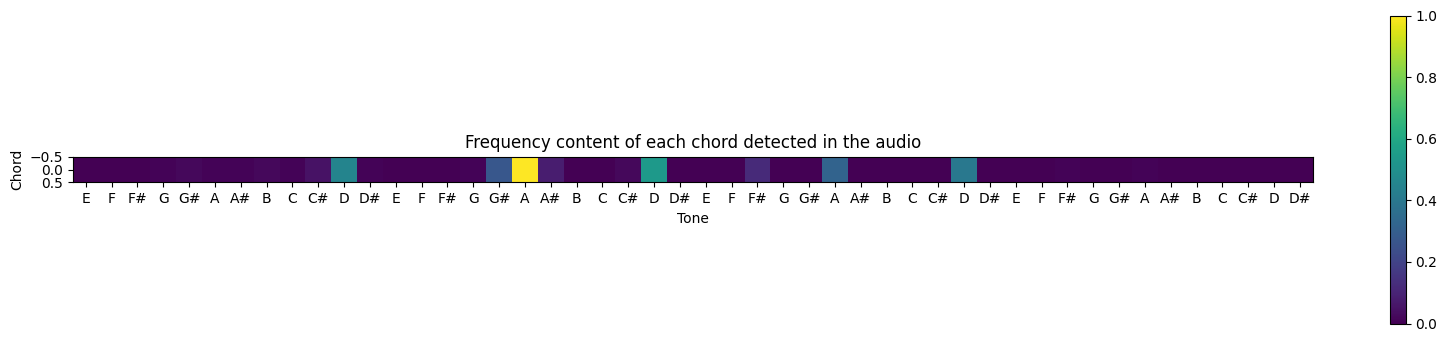

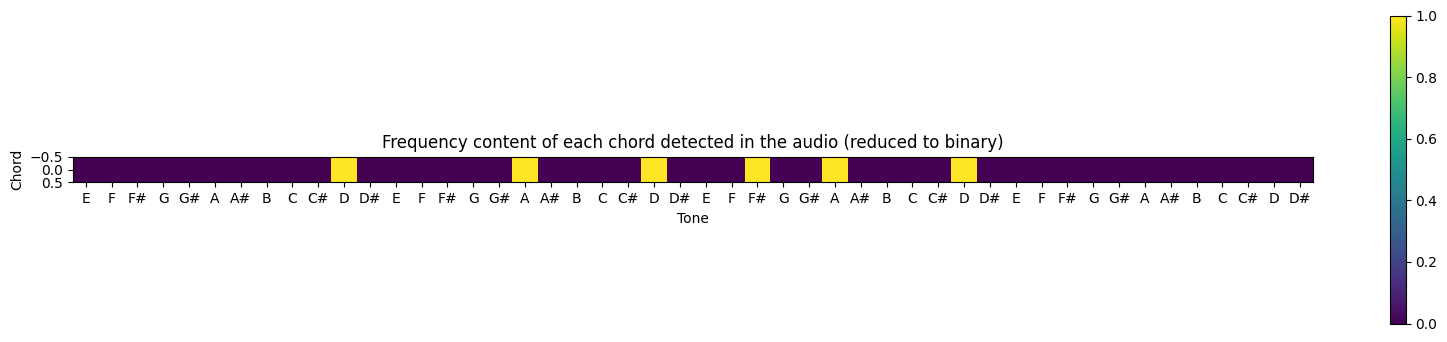

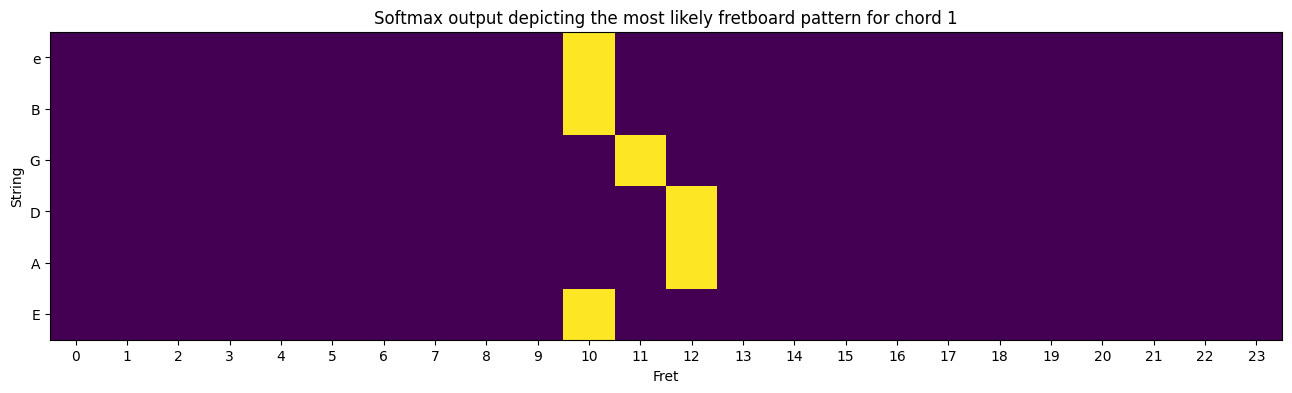


Guitar tablature:

 10 

 10 

 11 

 12 

 12 

 10 

Each plot below corresponds to a single chord shape
The plots depict how the model characterizes a given fretboard pattern (a column in the tablature) based on three key characterisitics
First characteristic: what fret is the pattern played at? 0-24
Second characteristic: which of the basic chord shapes does the pattern use? C/A/G/E/D
Third characteristic: how does the pattern modify the basic pattern? major/minor
So far, I have only trained the model to recognize major or minor modifications
However, I can easily incorporate 7ths, 6ths, 9ths, dim, aug, sus et al. shapes into the training dataset

The model classifies each column of tablature (each fretboard pattern) in this way
For key classification, which is the next step in my model, each fretboard pattern is assigned a unique token only based on these three characteristics
This method of chord classification therefore allows my model to recognize the different ways of playing

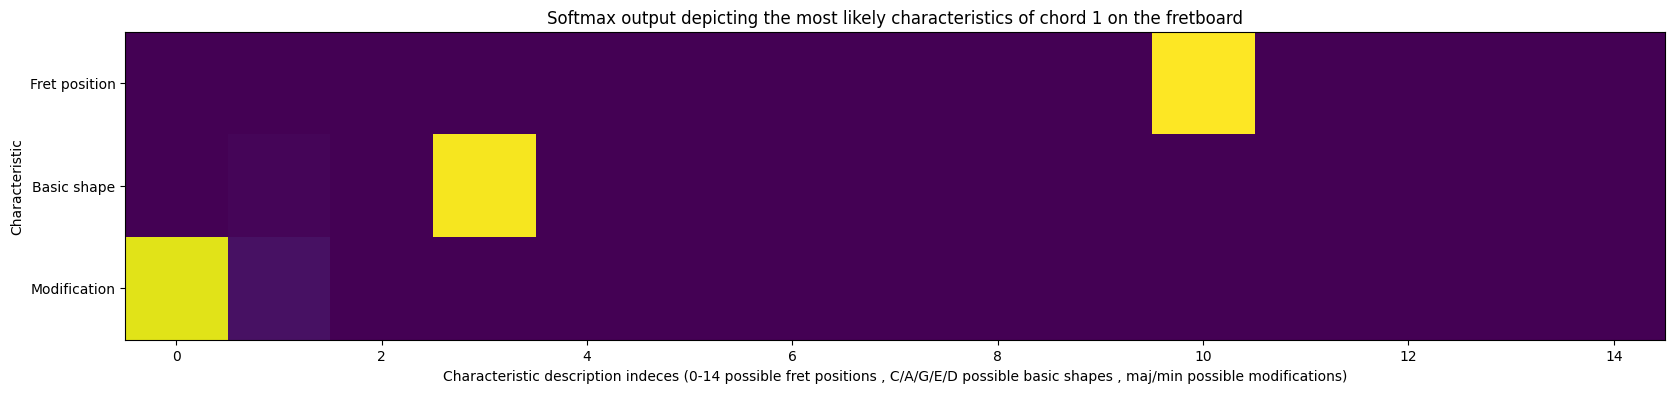


The model guesses that chord 1 has a bar at fret 10, using the E chord shape in its major form.

Chord 1 guess: D



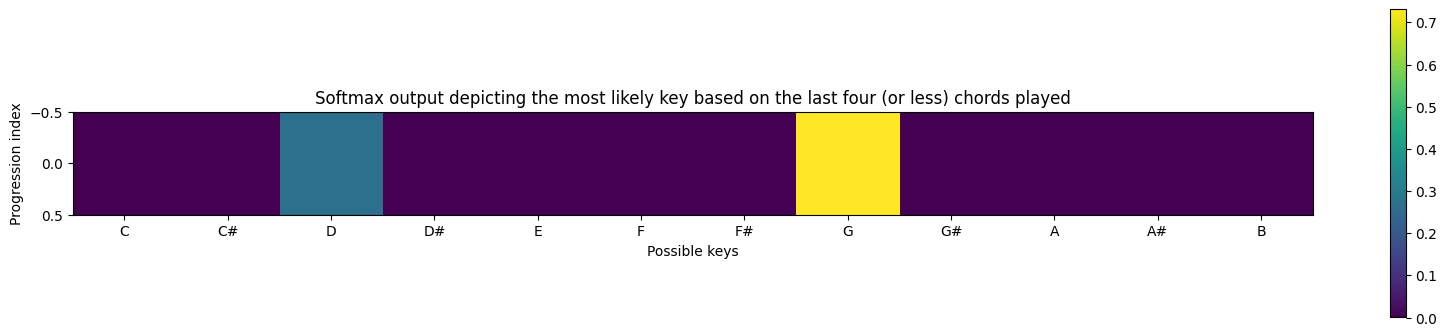


Key guess: G


In [187]:
tab, pattern, chord, key = convert('Dmaj.wav',play_audio=True,make_plots=True)